# Week 10: Colab Experiment

# I. Introduction
In this exercise, we apply CNN to MNIST data to classify the hand written digits.

In [415]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# Data Loading
Load the data from the MNIST dataset

In [417]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Visualize dataset sample
Show some sample.

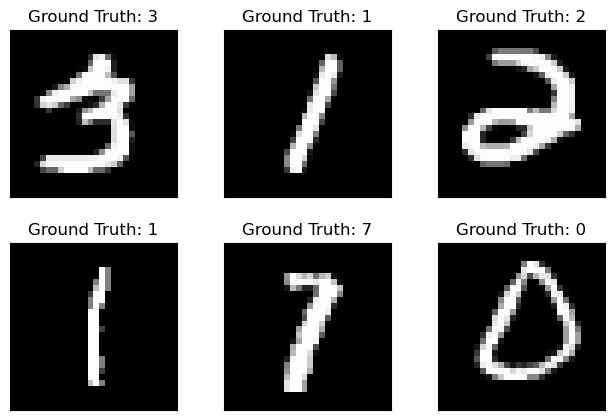

In [419]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods


In [421]:
from os import X_OK

# This class implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Valid convolution, 1 channel in, 2 channels out, stride 1, kernel size = 3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        # Dropout for convolutions
        self.drop = nn.Dropout2d()
        # Fully connected layer
        self.fc1 = nn.Linear(338, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.log_softmax(x)
        return x



In [455]:
# TODO: Change above Net to Net2 class to implement

# 1. A valid convolution with kernel size 5, 1 input channel, and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels, and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.


# New class implementing the specified architecture
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        # First convolutional block: 1 input channel, 10 output channels, kernel size 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)  # 2x2 max pooling
        self.relu = nn.ReLU()
        
        # Second convolutional block: 10 input channels, 20 output channels, kernel size 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d(p=0.4)  # Dropout layer after the second convolution

        # I added a third convolutional block for better performance
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(30)
        
        # Flattening and fully connected layers
        # We'll determine input size for the first fully connected layer dynamically in forward
        self.fc1 = None  # Placeholder, to be initialized in the forward method
        self.fc2 = nn.Linear(50, 10)  # Final output to 10 classes
        
    def forward(self, x):
        # First conv block: Conv -> ReLU -> Max Pool
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second conv block: Conv -> ReLU -> Max Pool -> Dropout
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.drop(x)

        # Third conv block: Conv -> BatchNorm -> ReLU
        x = F.relu(self.conv3_bn(self.conv3(x)))
        
        # Flattening operation
        x = x.view(x.size(0), -1)
        
        # Initialize the first fully connected layer dynamically (if not already done)
        if self.fc1 is None:
            input_dim = x.size(1)
            self.fc1 = nn.Linear(input_dim, 50)
            nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')  # Optional weight initialization
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [423]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [424]:
# Main training routine
# TODO: Read it and understand what it does, you would need to implement it in the next colab HW

# define the training of the model for a single epoch
def train(epoch, model):
  model.train() # set the model to training mode
  # Get each, iterate over batches of data from the train_loader
  for batch_idx, (data, target) in enumerate(train_loader): 
    optimizer.zero_grad() # zero the gradients
    output = model(data) # data is passed through the model to get predictions
    loss = F.nll_loss(output, target)  # using the negative log-likelihood
    loss.backward() # compute the gradients of the model’s parameters with respect to the loss using backpropagation
    optimizer.step() # update the model's parameters (weights and biases) using the optimizer
    # Store results
    if batch_idx % 10 == 0:
      # Every 10th batch, print the current loss and training progress
      pred = output.data.max(1, keepdim=True)[1]
      correct = pred.eq(target.data.view_as(pred)).sum()
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [425]:
# Run on test data
# TODO: Read it and understand what it does, you would need to implement it in the next colab HW

def test(model):
  model.eval() # set the model to evaluation mode, dropout is disabled, and batch normalization uses the running statistics rather than batch statistics
  test_loss = 0
  correct = 0
  with torch.no_grad(): # prevent PyTorch from calculating gradients during inference
    for data, target in test_loader:
      output = model(data)
      # compute the negative log-likelihood loss between the model’s output (output) and the true labels (target)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # select the class with the highest score for each sample in the batch
      pred = output.data.max(1, keepdim=True)[1]
      # count correct predictions
      correct += pred.eq(target.data.view_as(pred)).sum()
  # average loss per example
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [426]:
# Train and test Model 1

# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Get initial performance
test(model)
# Train for ten epochs
n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch, model)
accuracy1 = test(model)


/var/folders/44/03rd9m156sx7chkdv0lzxt240000gn/T/ipykernel_12892/1265220663.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)



Test set: Avg. loss: 2.3277, Accuracy: 959/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.397596
Train Epoch: 1 [640/60000]	Loss: 2.314329
Train Epoch: 1 [1280/60000]	Loss: 2.313947
Train Epoch: 1 [1920/60000]	Loss: 2.287558
Train Epoch: 1 [2560/60000]	Loss: 2.202006
Train Epoch: 1 [3200/60000]	Loss: 2.182694
Train Epoch: 1 [3840/60000]	Loss: 2.251300
Train Epoch: 1 [4480/60000]	Loss: 2.221143
Train Epoch: 1 [5120/60000]	Loss: 2.041233
Train Epoch: 1 [5760/60000]	Loss: 2.026867
Train Epoch: 1 [6400/60000]	Loss: 1.910887
Train Epoch: 1 [7040/60000]	Loss: 1.915868
Train Epoch: 1 [7680/60000]	Loss: 1.655506
Train Epoch: 1 [8320/60000]	Loss: 1.730156
Train Epoch: 1 [8960/60000]	Loss: 1.589088
Train Epoch: 1 [9600/60000]	Loss: 1.595941
Train Epoch: 1 [10240/60000]	Loss: 1.646502
Train Epoch: 1 [10880/60000]	Loss: 1.620031
Train Epoch: 1 [11520/60000]	Loss: 1.555584
Train Epoch: 1 [12160/60000]	Loss: 1.482594
Train Epoch: 1 [12800/60000]	Loss: 1.740577
Train Epoch: 1 [13440/60000]	Loss: 1.46

In [457]:
# Train and test Model 2

# Create network
model2 = Net2()
# Initialize model weights
model2.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)

# Get initial performance
test(model2)
# Train for ten epochs
n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch, model2)
accuracy2 = test(model2)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3558, Accuracy: 574/10000 (6%)

Train Epoch: 1 [0/60000]	Loss: 2.610677
Train Epoch: 1 [640/60000]	Loss: 2.194091
Train Epoch: 1 [1280/60000]	Loss: 1.605685
Train Epoch: 1 [1920/60000]	Loss: 1.473536
Train Epoch: 1 [2560/60000]	Loss: 1.353008
Train Epoch: 1 [3200/60000]	Loss: 1.129176
Train Epoch: 1 [3840/60000]	Loss: 1.219146
Train Epoch: 1 [4480/60000]	Loss: 1.098599
Train Epoch: 1 [5120/60000]	Loss: 1.128591
Train Epoch: 1 [5760/60000]	Loss: 1.055942
Train Epoch: 1 [6400/60000]	Loss: 0.749715
Train Epoch: 1 [7040/60000]	Loss: 0.793017
Train Epoch: 1 [7680/60000]	Loss: 0.817365
Train Epoch: 1 [8320/60000]	Loss: 0.962840
Train Epoch: 1 [8960/60000]	Loss: 0.825756
Train Epoch: 1 [9600/60000]	Loss: 0.738609
Train Epoch: 1 [10240/60000]	Loss: 0.723809
Train Epoch: 1 [10880/60000]	Loss: 0.855613
Train Epoch: 1 [11520/60000]	Loss: 0.643409
Train Epoch: 1 [12160/60000]	Loss: 0.709093
Train Epoch: 1 [12800/60000]	Loss: 0.579134
Train Epoch: 1 [13440/60000]	Loss: 0.540

## III. Results

Here we train the CNN model and apply it to the test set. There are 10 epochs in training. There is no validation set here, we simply take the model at the end of the training procedure.

In [459]:
print(f"Model 1 Accuracy: {round(float(accuracy1.numpy()),2)}%")
print(f"Model 2 Accuracy: {round(float(accuracy2.numpy()),2)}%")

Model 1 Accuracy: 92.7%
Model 2 Accuracy: 98.77%


/var/folders/44/03rd9m156sx7chkdv0lzxt240000gn/T/ipykernel_12892/1265220663.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


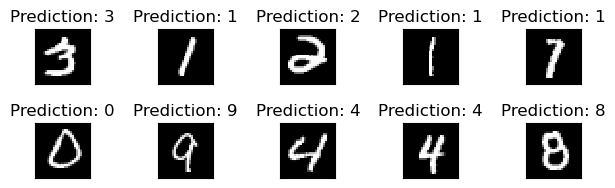

In [461]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

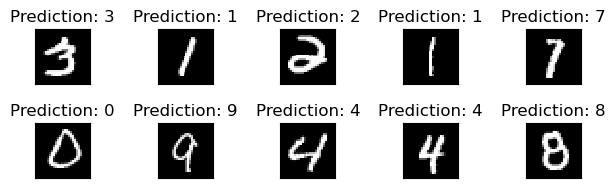

In [463]:
# Run network on data we got before and show predictions
output = model2(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

# IV. Conclusion and Discussion

The change from `Net` to `Net2` brought a noticeable accuracy boost from 92.7% to 98.77%, showing how modifying a neural network's structure can make a difference. Adding more convolutional layers with smaller kernels, `Net2` can capture more complex and detailed features from the input data, which helps it learn better. Adding batch normalization after each convolution layer also helps keep the inputs to each layer more stable, making training faster and more reliable.

Another useful addition was the dropout layer, which randomly turns off some neurons during training to prevent overfitting. This helps make the model generalize better when it sees new data. The global average pooling layer reduces the size of the feature maps before they go into the fully connected layers, which lowers the number of parameters without losing important information.

Using Kaiming weight initialization also makes the training process smoother, ensuring signals flow better through the layers. Overall, these improvements make `Net2` more powerful and efficient at recognizing patterns in the data. Adding layers, regularization, and normalization can significantly improve a model's accuracy and reliability.